In [5]:
import sys
import os
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR100, MNIST
from torchvision import transforms
from tqdm import trange
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import umap.umap_ as umap
from pytorch_pretrained_vit import ViT
import json
import PIL
from tqdm import tqdm, trange
from colors import blue, red, green, cyan
from collections import Counter
from transformers import BertTokenizer
import ruamel_yaml as yaml
from scipy.optimize import linear_sum_assignment
import math

# sys.path.append('ANONYMOUS_ROOTDIR/develop/open-world/CLIP')
import clip
from clip.model import CLIP

In [2]:
data = json.load(open('ANONYMOUS_ROOTDIR/data/COCO/annotations/captions_val2017.json'))
id2file = {item['id']: item['coco_url'] for item in data['images']}
id2caption = {item['image_id']: item['caption'] for item in data['annotations']}
file2caption = {id2file[id]: id2caption[id] for id in id2caption}
filenames = [(filename, file2caption[filename]) for filename in file2caption]

In [6]:
device = "cuda"

################################## PRETRAIN ##################################
model, preprocess = clip.load('ViT-B/16', device)
################################## PRETRAIN ##################################
model = CLIP(
        embed_dim=512,
        image_resolution=224, 
        vision_layers=12, 
        vision_width=768, 
        vision_patch_size=16,
        context_length=77, 
        vocab_size=49408, 
        transformer_width=512, 
        transformer_heads=8, 
        transformer_layers=12
    ).to(device)
model.eval()

image_features, text_features, image_inputs, text_inputs = [], [], [], []
for filename in tqdm(file2caption):
    
    caption = file2caption[filename]
    filename = f"ANONYMOUS_ROOTDIR/data/COCO/{filename.replace('http://images.cocodataset.org/', '')}"
    
    im = PIL.Image.open(filename)
    image_input = preprocess(im).unsqueeze(0).to(device)
    text_input = clip.tokenize(caption).to(device)
    with torch.no_grad():

        image_feature = model.encode_image(image_input)
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
        image_feature = image_feature.cpu().numpy()[0]

        text_feature = model.encode_text(text_input)
        text_feature /= text_feature.norm(dim=-1, keepdim=True)
        text_feature = text_feature.cpu().numpy()[0]
    
    image_inputs.append(image_input.cpu().numpy()[0])
    text_inputs.append(text_input.cpu().numpy()[0])
    image_features.append(image_feature)
    text_features.append(text_feature)

    if len(image_features) == 500: break

image_inputs = torch.tensor(image_inputs)
text_inputs = torch.tensor(text_inputs)
image_features = torch.tensor(image_features)
text_features = torch.tensor(text_features)

 10%|▉         | 499/5000 [00:44<06:45, 11.10it/s]
/tmp/ipykernel_2469039/1990546171.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  image_inputs = torch.tensor(image_inputs)


In [16]:
((image_features @ text_features.T).argmax(dim=-1) == torch.arange(500)).float().mean()

tensor(0.0020)

In [7]:
np.save('features_clip_random.npy', [image_features.float().numpy(), text_features.float().numpy()])

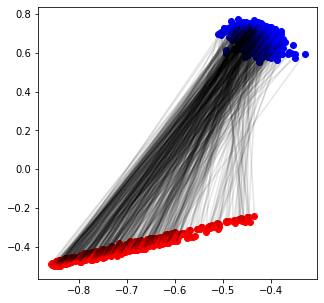

In [17]:
# Use PCA to reduce dimensionality
all_img_features, all_text_features = np.load('features_clip_random.npy')

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(np.concatenate([all_img_features, all_text_features], 0))
plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='red')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='blue')
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='black', alpha=0.1)

In [4]:
import sys
import os
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR100, MNIST
from torchvision import transforms
from tqdm import trange
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
# import umap.umap_ as umap
import umap
from pytorch_pretrained_vit import ViT
import json
import PIL
from tqdm import tqdm, trange
# from colors import blue, red, green, cyan
from collections import Counter
from transformers import BertTokenizer
import ruamel_yaml as yaml
from scipy.optimize import linear_sum_assignment
import math

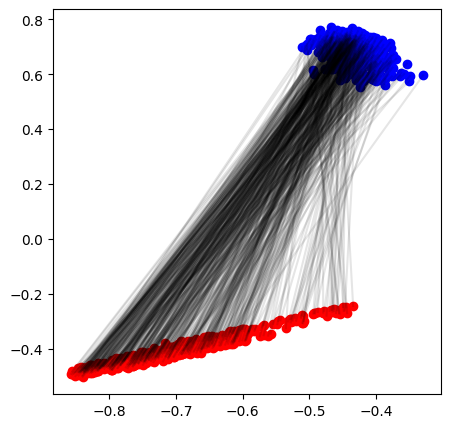

In [5]:
# Use PCA to reduce dimensionality
all_img_features, all_text_features = np.load('features_clip_random.npy')

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(np.concatenate([all_img_features, all_text_features], 0))
plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='red')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='blue')
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='black', alpha=0.1)